## Intro

The webpage we have selected from the forums is titled 'Chronic Car Buyers Anonymous,' accessible at https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous. This group consists of individuals who frequently go car shopping and share their thoughts about various cars. Analyzing the discussions and preferences of this group provides valuable insights into consumer trends and preferences, which can significantly benefit automotive businesses in tailoring their marketing strategies and product development.

## 1. Data Scraping

In [2]:
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

entries = []
entry = []
urlnumber = 2 # Give the page number to start with


while urlnumber < 150: # Give the page number to end with

    url = 'https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

## 2. Data Pre-processing
The goal of this part is to 1) extract unique brand names from each comment, and 2) tokenize the comments so that further insights can be generated based on the key attributes mentioned. The output is a cleansed dataframe, which everyone can use to perform analytics based on their use cases. Additionally, the output is also saved as an Excel file for those who would like to review it firsthand.

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

Loading the brands and models, clean up and change to lowercase; Creating a dictionary to store them in key value pairs

In [4]:
# Define a function to clean the text
def clean_text(text):
    # Replace or remove unwanted characters here
    text = text.replace(',', '').replace('.', '')
    return text.strip().lower()

# Read the csv file into a dataframe
brand_model_data = pd.read_csv('models.csv', header=None)
brand_model_data.columns = ['Brand', 'Model']

# Remove the row where the Brand is 'car'
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'car']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'seat']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'problem']

# Ensure the columns are named correctly
brand_model_data.columns = ['Brand', 'Model']

# Creating a dictionary with the brand as key and a list of unique models as value
brand_model_dict = {}
for index, row in brand_model_data.iterrows():
    # Apply cleaning function to brand and model
    brand = clean_text(row['Brand'])
    model = clean_text(row['Model'])

    if brand in brand_model_dict:
        # Add the model to the brand's list if it's not already there
        if model not in brand_model_dict[brand]:
            brand_model_dict[brand].append(model)
    else:
        brand_model_dict[brand] = [model]

# Formatting the output for better readability with all models
for brand, models in brand_model_dict.items():
    models_list = ", ".join(models)
    print(f"{brand}: {models_list}")

acura: integra, legend, vigor, rlx, ilx, mdx, rdx, tsx, rsx, is
audi: quattro, a4, a6, a5, a7, q3, q5, q7, a8, a3
bmw: 3-series, 5-series, 6-series, 4-series, xdrive, alpina, 330ci, 328i, 330c, 335i, 335d, 528i, 535i, 128i, 640i, 3er, 5er, m5, m3, m6, bmws, bmwesque
buick: park avenue, la crosse, lacrosse, century, enclave, encore, regal, buicks
cadillac: escalade, srx, xts
chevrolet: grand blazer, trailblazer, silverado, colorado, corvette, suburban, cavalier, caprice, captiva, equinox, express, lacetti, montana, uplander, orlando, tornado, tracker, traverse, camaro, cobalt, impala, lumina, malibu, prisma, tavera, agile, celta, cruze, lanos, omega, optra, sonic, spark, tahoe, aveo, lova, n200, niva, onix, s-10, sail, volt, chevy, malibus
chrysler: town and country, chrysler 300, chrysler 200, pacifica, cruiser, sebring, 300m, lx, chryslers
dodge: challenger, intrepid, avenger, charger, durango, journey, caliber, stealth, magnum, viper, dart, ram
ford: crownvictoria, expedition, superv

Change the comments to lowercase, and replace the models with brand names where neccessary

In [5]:
# Function to replace model names with brand names in a comment
def replace_models_with_brands(comment, brand_model_dict):
    for brand, models in brand_model_dict.items():
        for model in models:
            if model in comment:
                comment = comment.replace(model, brand)
    return comment

# Function to list unique occurrences of brand names in a comment
def list_unique_brands(comment, brand_model_dict):
    unique_brands = set()
    for brand in brand_model_dict.keys():
        if brand in comment:
            unique_brands.add(brand)
    return ", ".join(unique_brands)

# Load the comments data file
forum_data = pd.read_csv('edmunds_extraction.csv', header=None)

# Clean and lowercase all text in the comments
forum_data.iloc[:, 2] = forum_data.iloc[:, 2].apply(clean_text)

# Apply the function to replace models with brands in each comment
forum_data['Processed Text'] = forum_data.iloc[:, 2].apply(lambda comment: replace_models_with_brands(comment, brand_model_dict))

# Apply the function to list unique brands in each comment
forum_data['Brands Mentioned'] = forum_data['Processed Text'].apply(lambda comment: list_unique_brands(comment, brand_model_dict))

# Display the processed data
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda"
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,"acura, chevrolet"
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,"acura, chevrolet"


Count the Top 10 Popular Cars

In [6]:
from collections import Counter
import pandas as pd

# Combine all brand names into a single list
all_brands = []
for brands in forum_data['Brands Mentioned']:
    # Split the brands and add to the list, skipping empty entries
    all_brands.extend([brand for brand in brands.split(', ') if brand])

# Count the occurrences of each brand
brand_counts = Counter(all_brands)

# Convert the counter to a DataFrame for better readability
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Occurrences'])

# Sort the DataFrame by occurrences in descending order
brand_counts_df = brand_counts_df.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(brand_counts_df)

         Brand  Occurrences
0        acura         5351
1        honda         1799
2       toyota         1547
3         ford          741
4        dodge          685
5       nissan          683
6          bmw          639
7    chevrolet          563
8       subaru          397
9   volkswagen          377
10       mazda          299
11    chrysler          298
12        audi          275
13     pontiac          271
14     hyundai          267
15      saturn          252
16       volvo          248
17       sedan          211
18    mercedes          188
19        mini          178
20     lincoln           77
21    cadillac           61
22     mercury           54
23       buick           51
24         kia           45
25    infiniti           39
26      suzuki           24
27  mitsubishi            9


In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

brand_list=set(brand_counts_df["Brand"])

# Step 1: Remove Car Brands
def remove_brands(text, brand_list):
    for brand in brand_list:
        text = text.replace(brand, "")
    return text

# Step 2: Lemmatize Function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Step 3: Remove Stop Words and Punctuation, and Filter Single Letters
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())
punctuation = set(string.punctuation)

def filter_words(words):
    unique_words = set()  # Initialize an empty set to store unique words
    for word in words:
        if (word not in stop_words 
            and word not in punctuation
            and word not in ["''", "``", "--"]
            and len(word) > 1 
            and not re.search("(n't|'s|'m|'ve|'d|'ll|'re)$", word)
            and not re.fullmatch(r"\.{2,}", word)):
            unique_words.add(word)
    return list(unique_words)


# Step 4: Process and Add to DataFrame
forum_data['Words List'] = forum_data['Processed Text'].apply(lambda x: remove_brands(x, brand_list))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: lemmatize_text(x))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: filter_words(x))

[nltk_data] Downloading package punkt to /Users/emilywu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emilywu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/emilywu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[power, choice, premium, underpowered, 30mpg, ..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[15, v8, turn, 70mph, mpg, gear, automatic, 37..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[78, tie, turn, temp, 70, road, mph, tach, rod..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,"acura, chevrolet","[trip, package, college, '77, point, gas, high..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,"acura, chevrolet","[thing, enjoy, boat, relive, car, friend, 78, ..."


In [9]:
attribute_counts = pd.Series([attribute for sublist in forum_data['Words List'] for attribute in sublist]).value_counts()
print(attribute_counts)

car              3076
drive            1637
year             1564
good             1543
buy              1527
                 ... 
feel'funny'if       1
17/23               1
cartmaybe           1
themregarding       1
storeof             1
Length: 25879, dtype: int64


In [10]:
attributes_df = attribute_counts.reset_index()
attributes_df.columns = ['Attribute', 'Count']

In [11]:
attributes_df.head(200)

,Attribute,Count
0,car,3076
1,drive,1637
2,year,1564
3,good,1543
4,buy,1527
5,time,1109
6,mile,1009
7,thing,925
8,nice,839
9,lot,819


In [12]:
#forum_data.to_excel("after_extracted_make.xlsx")

## 3. Analysis

### Task A

### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task. Show the brands on a multi-dimensional scaling (MDS) map.

Top 10 Brands Selected

In [13]:
# Identify top 10 brands by frequency
all_brands = []
for brands in forum_data['Brands Mentioned']:
    all_brands.extend([brand for brand in brands.split(', ') if brand])
brand_counts = Counter(all_brands)
top_10_brands = [brand for brand, count in brand_counts.most_common(10)]

In [14]:
top_10_brands

['acura',
 'honda',
 'toyota',
 'ford',
 'dodge',
 'nissan',
 'bmw',
 'chevrolet',
 'subaru',
 'volkswagen']

Calculate the lift ratio and generate the MDS map

Lift Ratios between Brand Pairs:
      Brand 1     Brand 2  Lift Ratio
0       dodge      nissan    2.562332
1        ford   chevrolet    2.341419
2      subaru  volkswagen    2.175467
3        ford       dodge    2.099353
4        ford  volkswagen    1.986705
5       dodge   chevrolet    1.957190
6   chevrolet      subaru    1.887155
7      toyota       dodge    1.773718
8        ford      nissan    1.696097
9      nissan   chevrolet    1.674256
10  chevrolet  volkswagen    1.673490
11        bmw  volkswagen    1.658759
12     toyota        ford    1.646127
13     toyota      nissan    1.638840
14     toyota      subaru    1.614566
15     toyota   chevrolet    1.614309
16       ford      subaru    1.534450
17      honda      subaru    1.533458
18      honda      toyota    1.512943
19     nissan  volkswagen    1.465682
20     toyota  volkswagen    1.446455
21      honda      nissan    1.433365
22      honda        ford    1.315621
23      honda  volkswagen    1.309304
24      dodge    

/Users/emilywu/anaconda3/envs/Conda_3117/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/emilywu/anaconda3/envs/Conda_3117/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


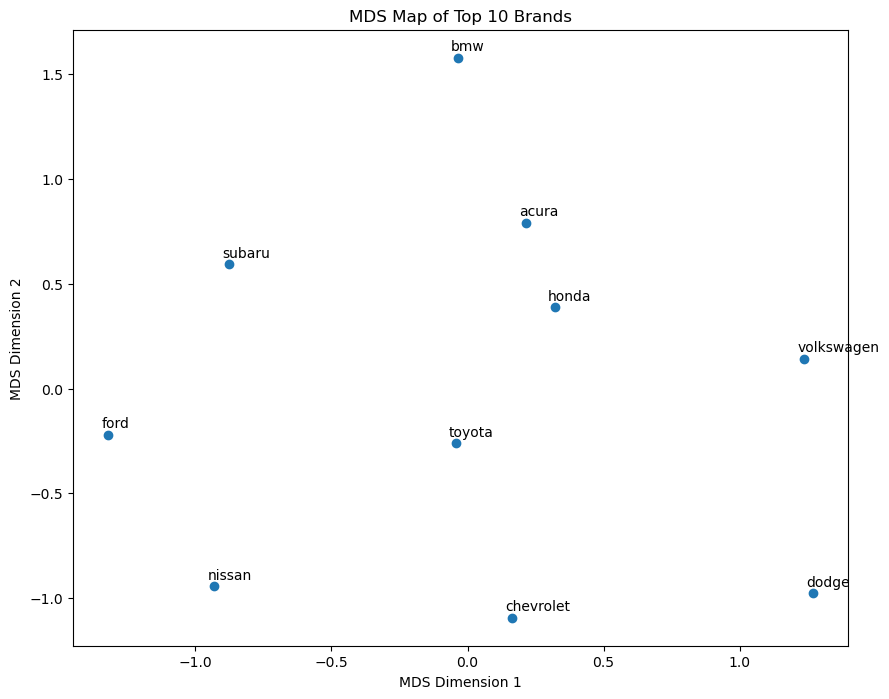

In [15]:
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculate Lift Ratios
def calculate_lift(brand1, brand2, data):
    total_posts = len(data)
    brand1_count = sum(brand1 in brands for brands in data['Brands Mentioned'])
    brand2_count = sum(brand2 in brands for brands in data['Brands Mentioned'])
    both_count = sum(brand1 in brands and brand2 in brands for brands in data['Brands Mentioned'])
    return (total_posts * both_count) / (brand1_count * brand2_count) if brand1_count and brand2_count else 0

lift_matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
lift_ratios = []

# Only calculate lift for unique brand pairs
for i, brand1 in enumerate(top_10_brands):
    for brand2 in top_10_brands[i+1:]:
        lift = calculate_lift(brand1, brand2, forum_data)
        lift_matrix.loc[brand1, brand2] = lift
        lift_matrix.loc[brand2, brand1] = lift  # Symmetric
        lift_ratios.append((brand1, brand2, lift))

# Create a DataFrame for lift ratios
lift_df = pd.DataFrame(lift_ratios, columns=['Brand 1', 'Brand 2', 'Lift Ratio'])
lift_df = lift_df.sort_values(by='Lift Ratio', ascending=False).reset_index(drop=True)

# Display the DataFrame of lift ratios
print("Lift Ratios between Brand Pairs:")
print(lift_df)

# Replace NaN values in the lift matrix with 1 (indicating no lift)
lift_matrix = lift_matrix.fillna(1)

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=0)
mds_coords = mds.fit_transform(lift_matrix)

# Plot MDS map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], marker='o')
for label, x, y in zip(top_10_brands, mds_coords[:, 0], mds_coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-5, 5), textcoords='offset points')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Map of Top 10 Brands')
plt.show()

**Task C**

In [17]:
top_5_brands = sorted(top_10_brands)[:5]
print(top_5_brands)

['acura', 'bmw', 'chevrolet', 'dodge', 'ford']


In [18]:
top_100_attributes = attributes_df['Attribute'][0:100]

# Updated list of car-related terms
car_related_terms = [
    'engine', 'transmission', 'brakes', 'suspension', 'steering', 'tires', 'wheels',
    'fuel ', 'safety features', 'price', 'reliability', 'brand', 'design', 'efficiency',
    'comfort', 'interior', 'resale value', 'technology features', 'warranty',"repair","kid","trip","family","road",  
    'maintenance', 'emissions', 'space', 'costs', 'cost',"sound","gas","cheap","price","wheel","power","wagon","acceleration","speed","mileage","mpg","mile"
]

# Initialize an empty dictionary to store ranks and a list for non-car-related terms
car_related_ranks = {}
non_car_related_terms = []

# Iterate over the top_100_attributes list
for rank, attribute in enumerate(top_100_attributes, start=1):
    if attribute in car_related_terms:
        car_related_ranks[attribute] = rank
    else:
        non_car_related_terms.append(attribute)

# car_related_ranks will have the car-related terms and their ranks
# non_car_related_terms will have the attributes that are not car-related
print("Car-related terms and their ranks:", car_related_ranks)
print("Non-car-related terms:", non_car_related_terms)

Car-related terms and their ranks: {'mile': 7, 'price': 11, 'cost': 39, 'mileage': 42, 'wheel': 45, 'gas': 46, 'sound': 47, 'engine': 48, 'interior': 57, 'cheap': 60, 'warranty': 65, 'kid': 66, 'power': 77, 'wagon': 79, 'road': 82, 'repair': 91, 'mpg': 98}
Non-car-related terms: ['car', 'drive', 'year', 'good', 'buy', 'time', 'thing', 'nice', 'lot', 'dealer', 'sell', 'work', 'pretty', 'pay', 'vehicle', 'month', 'great', 'big', 'deal', 'day', 'truck', 'bad', 'trade', 'long', 'seat', 'wife', 'guess', 'start', 'problem', 'model', 'people', 'love', 'money', 'week', 'couple', 'bit', 'lease', 'ago', 'tire', 'guy', 'check', 'stick', 'high', 'kind', 'small', 'low', 'hard', 'leave', 'today', 'turn', 'change', 'figure', 'fun', 'replace', 'yeah', 'worth', 'offer', 'close', 'feel', 'live', 'sue', 'sit', 'talk', 'door', 'pick', 'reason', 'payment', 'fit', 'driver', 'idea', 'friend', 'house', 'point', 'spend', 'wait', 'auto', 'hear', 'real', 'expensive', 'rear', 'stuff', 'purchase', 'option']


In [19]:
# Sorting the car_related_ranks dictionary by its values (ranks) and extracting the top 10 keys
top_10_attributes = sorted(car_related_ranks, key=car_related_ranks.get)[:10]


# Initialize dictionaries to store counts
brand_counts = {brand: 0 for brand in top_5_brands}
attribute_counts = {attribute: 0 for attribute in top_10_attributes}
co_occurrence_counts = {(brand, attribute): 0 for brand in top_5_brands for attribute in top_10_attributes}

# Count the occurrences and co-occurrences
for _, row in forum_data.iterrows():
    brands_mentioned = row['Brands Mentioned']
    words_list = row['Words List']
    
    for brand in top_5_brands:
        if brand in brands_mentioned:
            brand_counts[brand] += 1
            for attribute in top_10_attributes:
                if attribute in words_list:
                    co_occurrence_counts[(brand, attribute)] += 1

    for attribute in top_10_attributes:
        if attribute in words_list:
            attribute_counts[attribute] += 1

# Total number of rows
total_rows = len(forum_data)

# Prepare a list to store the results
lift_data = []

# Calculate lift for each brand-attribute pair
for brand in top_5_brands:
    for attribute in top_10_attributes:
        p_a = brand_counts[brand] / total_rows
        p_b = attribute_counts[attribute] / total_rows
        p_a_and_b = co_occurrence_counts[(brand, attribute)] / total_rows
        lift = p_a_and_b / (p_a * p_b)
        lift_data.append({"Brand": brand, "Attribute": attribute, "Lift": lift})

# Convert the list to a DataFrame
lift_df = pd.DataFrame(lift_data)
lift_df = lift_df.sort_values(by=["Brand", "Lift"], ascending=[True, False])

# Display the DataFrame
print(lift_df)


        Brand Attribute      Lift
7       acura    engine  1.243465
9       acura     cheap  1.238771
3       acura   mileage  1.229667
5       acura       gas  1.203863
1       acura     price  1.197561
2       acura      cost  1.185871
8       acura  interior  1.175481
0       acura      mile  1.158143
4       acura     wheel  1.153061
6       acura     sound  1.085476
12        bmw      cost  1.920099
16        bmw     sound  1.876186
18        bmw  interior  1.773279
11        bmw     price  1.628283
10        bmw      mile  1.377276
13        bmw   mileage  1.283338
14        bmw     wheel  1.230635
17        bmw    engine  1.135352
19        bmw     cheap  1.018489
15        bmw       gas  0.861367
27  chevrolet    engine  2.172237
28  chevrolet  interior  2.135879
22  chevrolet      cost  1.702574
23  chevrolet   mileage  1.699340
25  chevrolet       gas  1.556988
21  chevrolet     price  1.554466
24  chevrolet     wheel  1.396760
20  chevrolet      mile  1.315690
29  chevrolet 